In [8]:
import os
import time
import random
import numpy as np
from imutils import paths
import pandas as pd
from tqdm import tqdm
import json
import datetime
import cv2

import seaborn as sns


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
import plotly.express as px
import plotly.graph_objects as go



import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
from torchsummary import summary
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [9]:

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, AveragePooling2D, Input
from tensorflow.keras.optimizers import Adam


# Load Datasets

In [10]:
# Définir le chemin du dataset
train_dir = '../SF-MASK-dataset/train'
test_dir = '../SF-MASK-dataset/test'

# Compter les images dans chaque sous-dossier
train_compliant = len(os.listdir(os.path.join(train_dir, 'compliant')))
train_non_compliant = len(os.listdir(os.path.join(train_dir, 'non-compliant')))
test_compliant = len(os.listdir(os.path.join(test_dir, 'compliant')))
test_non_compliant = len(os.listdir(os.path.join(test_dir, 'non-compliant')))

print(f"Training dataset: Compliant: {train_compliant}, Non-compliant: {train_non_compliant}")
print(f"Test dataset: Compliant: {test_compliant}, Non-compliant: {test_non_compliant}")


Training dataset: Compliant: 21384, Non-compliant: 15772
Test dataset: Compliant: 3622, Non-compliant: 5048


## EDA

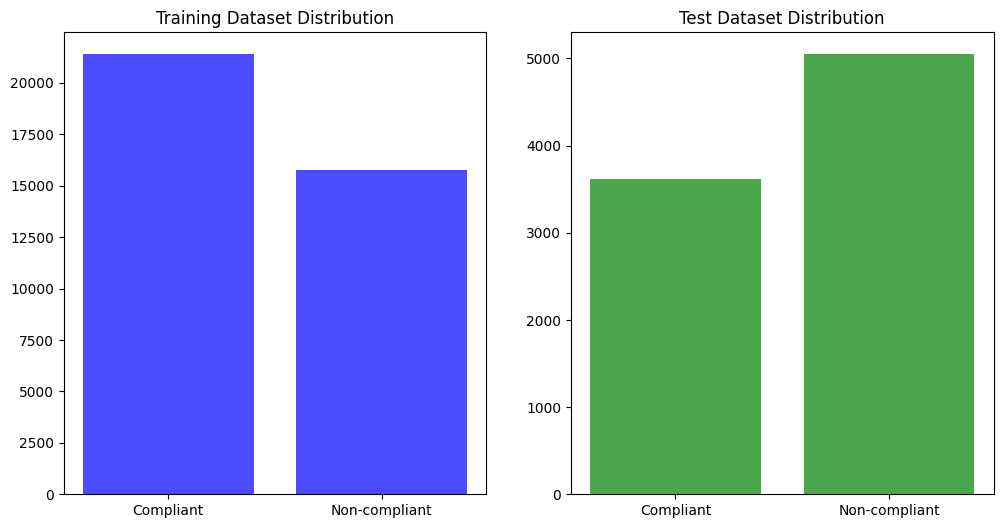

In [11]:
# Distribution des classes dans le dataset
categories = ['Compliant', 'Non-compliant']
train_counts = [train_compliant, train_non_compliant]
test_counts = [test_compliant, test_non_compliant]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(categories, train_counts, color='blue', alpha=0.7)
ax[0].set_title('Training Dataset Distribution')
ax[1].bar(categories, test_counts, color='green', alpha=0.7)
ax[1].set_title('Test Dataset Distribution')

plt.show()


Nous pourrons maintenant choisir une technique de redimensionnement basée sur les tailles les plus courantes, comme :

- Redimensionnement à une taille fixe (ex. 224x224).
- Maintien des proportions avec padding.
- Recadrage au centre.

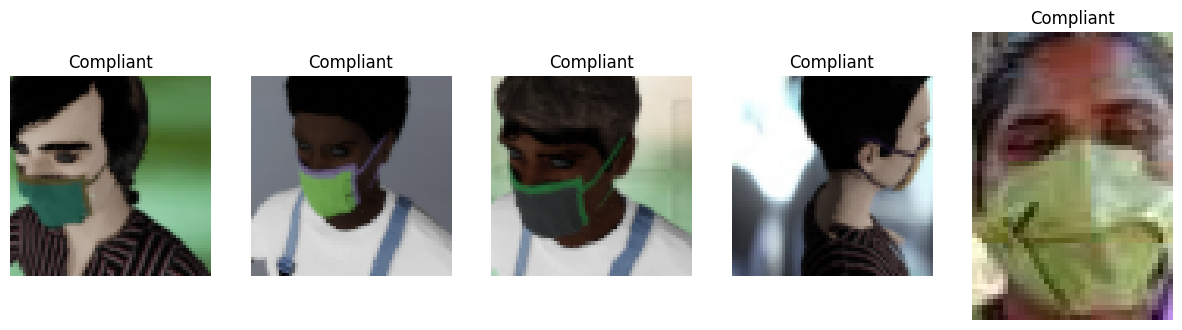

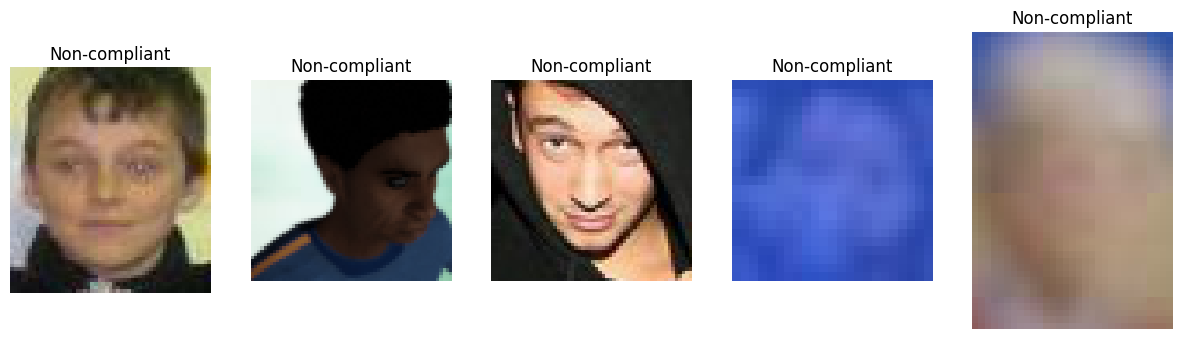

In [12]:
# Fonction pour afficher quelques images d'exemple
def display_images_from_folder(folder, label, num_images=5):
    images = os.listdir(folder)
    random_images = random.sample(images, num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img_name in enumerate(random_images):
        img_path = os.path.join(folder, img_name)
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(label)
    plt.show()

# Affichage d'exemples de chaque catégorie
display_images_from_folder(os.path.join(train_dir, 'compliant'), 'Compliant')
display_images_from_folder(os.path.join(train_dir, 'non-compliant'), 'Non-compliant')


2. Ajout de padding pour maintenir les proportions
Description :
Agrandit l'image de 64x64 à 224x224 en ajoutant des bandes noires ou blanches autour de l'image.
Préserve le ratio aspect de l'image d'origine.
Avantages :
Maintient les proportions et évite la distorsion.
Idéal pour des modèles qui tolèrent des zones neutres (comme MobileNet).
Inconvénients :
Peut inclure trop d'espace inutile dans l'image.

In [13]:
output_dir_train = "../SF-MASK-dataset-padded/train"
output_dir_test = "../SF-MASK-dataset-padded/test"

In [14]:
def pad_and_resize(input_dir, output_dir, target_size=(224, 224)):
    os.makedirs(output_dir, exist_ok=True)
    for category in os.listdir(input_dir):
        category_path = os.path.join(input_dir, category)
        output_category_path = os.path.join(output_dir, category)
        os.makedirs(output_category_path, exist_ok=True)
        
        for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            input_path = os.path.join(category_path, filename)
            output_path = os.path.join(output_category_path, filename)
            try:
                with Image.open(input_path) as img:
                    old_size = img.size  # (width, height)
                    ratio = float(target_size[0]) / max(old_size)
                    new_size = tuple([int(x * ratio) for x in old_size])
                    img_resized = img.resize(new_size, Image.Resampling.LANCZOS)  # Correction ici
                    
                    new_img = Image.new("RGB", target_size, (0, 0, 0))  # Black padding
                    new_img.paste(
                        img_resized,
                        ((target_size[0] - new_size[0]) // 2, (target_size[1] - new_size[1]) // 2),
                    )
                    new_img.save(output_path)
            except Exception as e:
                print(f"Erreur avec {input_path}: {e}")


In [15]:
# # Appliquer le padding sur les dossiers train et test
# pad_and_resize(train_dir, output_dir_train)
# pad_and_resize(test_dir, output_dir_test)

# FINE-TUNNING with Torch training pipeline

The code enhances the training pipeline, saving model weights, logging metrics, and generating useful plots. Additionally, it includes logging and the saving of metrics in a JSON file for later evaluation.

### Key Features of the Code:
1. **Model Training**:
   - Loads the MobileNetV2 model pretrained on ImageNet.
   - Adjusts the final classification layer to fit the number of classes in your dataset.
   - Saves the model weights after training (`mobilenetv2_trained.pth`).

2. **Metrics Logging**:
   - Saves key metrics such as the training loss, time per epoch, and model accuracy.
   - All the metrics are stored in a `training_metrics.json` file for later analysis.

3. **Plotting**:
   - Uses Plotly to plot the training loss and epoch times. These are displayed interactively in the notebook and saved as an HTML file for later review.

4. **Device Information**:
   - Tracks whether training is done on a GPU or CPU, and logs this in the metrics file.

5. **Saving & Loading the Model**:
   - After training, the model weights are saved to a file, making it easy to load and reuse later.

### Documentation (Markdown)
This script implements a training pipeline for MobileNetV2 on a custom dataset, which includes model training, evaluation, and saving key metrics and plots. The workflow includes:

1. **Data Preparation**: The dataset is loaded and preprocessed, including normalization and splitting for training and testing.
   
2. **Model Setup**: The pretrained MobileNetV2 model is loaded, and its classifier is adapted to fit the number of classes in the dataset.
   
3. **Training Process**: The model is trained for 3 epochs, with the loss and epoch time logged. The model weights are saved after training.

4. **Evaluation**: The trained model is evaluated on the test dataset, and accuracy is reported.

5. **Metrics and Visualization**:
   - Training metrics, including loss, epoch time, and accuracy, are saved to a JSON file.
   - Training progress is visualized using Plotly, with interactive plots saved as HTML.

### Enhancements and Additional Suggestions:
- **Model Fine-Tuning**: You can experiment with fine-tuning more layers of the MobileNetV2 model for improved performance.
- **Learning Rate Scheduling**: Incorporate learning rate schedulers to adjust the learning rate during training for better convergence.
- **Cross-Validation**: Consider using cross-validation for more robust model evaluation.

Let me know if you need further modifications or enhancements!

In [16]:
!nvidia-smi

Sat Nov 30 19:21:29 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.03                 Driver Version: 561.03         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8              9W /   35W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used : {device}")

CUDA is available. Using GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Device used : cuda


## Data Loader

In [27]:
# ========================
# Constants and Parameters
# ========================
BATCH_SIZE = 32 # Number of images in each batch
TRAIN_VAL_SPLIT = 0.8 # 80% for training, 20% for validation
DATASET_PROPORTION = 0.1  # Use a fraction of the dataset for faster training
MEAN, STD = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]  # Normalization parameters

# ========================
# Transforms
# ========================
def get_transforms(augment=False):
    """Return transforms for data preprocessing."""
    if augment:
        return transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD),
        ])
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD),
    ])
# ========================
# Dataset and Dataloader
# ========================
def load_dataset(data_dir, proportion=DATASET_PROPORTION, augment=False):
    """
    Load a dataset with optional data augmentation.
    
    Args:
        data_dir (str): Path to the dataset directory.
        proportion (float): Proportion of the dataset to use.
        augment (bool): Whether to apply data augmentation.
    
    Returns:
        torch.utils.data.Subset: Subset of the dataset.
    """
    transform = get_transforms(augment=augment)
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    subset, _ = random_split(
        dataset, 
        [int(len(dataset) * proportion), len(dataset) - int(len(dataset) * proportion)]
    )
    return dataset, subset

def split_train_val(train_dataset, split_ratio=TRAIN_VAL_SPLIT):
    """
    Split the training dataset into training and validation sets.
    
    Args:
        train_subset: Subset of the training dataset.
        split_ratio (float): Ratio for splitting training and validation datasets.
    
    Returns:
        Tuple[torch.utils.data.Subset, torch.utils.data.Subset]: Training and validation subsets.
    """
    train_size = int(len(train_dataset) * split_ratio)
    val_size = len(train_dataset) - train_size
    return random_split(train_dataset, [train_size, val_size]) #train_subset, val_subset = random_split(train_subset, [train_size, val_size])


def get_dataloaders(train_dir, test_dir, augment=False, batch_size=BATCH_SIZE):
    """
    Create DataLoaders for training, validation, and testing datasets.
    
    Args:
        train_dir (str): Path to the training data directory.
        test_dir (str): Path to the testing data directory.
        augment (bool): Whether to apply data augmentation to the training set.
        batcg_size (int): Number of images in each batch.
    
    Returns:
        Tuple[DataLoader, DataLoader, DataLoader]: Train, validation, and test DataLoaders.
    """
    train_dataset , train_subset = load_dataset(train_dir, augment=augment)
    test_dataset , test_subset = load_dataset(test_dir, augment=False)

    train_subset, val_subset = split_train_val(train_subset)
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)  # No shuffling for validation
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    
    return train_dataset, train_subset, val_subset , test_subset, train_loader, val_loader, test_loader

In [28]:
train_dataset, train_subset, val_subset , test_subset, train_loader, val_loader, test_loader = get_dataloaders(
    train_dir=output_dir_train, 
    test_dir=output_dir_test, 
    augment=True
)

print(f"We take {DATASET_PROPORTION*100}% of the entire dataset (size {len(train_dataset)})\n")
print(f"Train Subset: {len(train_subset)}, Val subset: {len(val_subset)}, Test subset: {len(test_subset)}")
print(f"Train Loader: {len(train_loader)}, Val Loader: {len(val_loader)}, Test Loader: {len(test_loader)}")

We take 10.0% of the entire dataset (size 37156)

Train Subset: 2972, Val subset: 743, Test subset: 867
Train Loader: 93, Val Loader: 24, Test Loader: 28


## Model training pipeline with only last layer modified


In [29]:
# ========================
# Early Stopping
# ========================
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ========================
# Metrics Visualization
# ========================
def plot_confusion_matrix(model, test_loader, classes, device):
    """Plot confusion matrix and print classification report."""
    y_true, y_pred = [], []
    model.eval()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(y_true, y_pred, target_names=classes))

In [42]:
# ========================
# Train Model Function (Updated)
# ========================
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs, training_time_name):
    print(f"size of train_loader : {len(train_loader)}, size of val_loader : {len(val_loader)}")
    print(f"Training {model.__class__.__name__} for {epochs} epochs...")
    training_metrics = []
    start_time = time.time()

    # Initialisation de l'early stopping
    early_stopping = EarlyStopping(patience=5, delta=0)

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate training accuracy and collect predictions/labels
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        train_accuracy = 100 * correct / total
        train_f1 = f1_score(all_labels, all_predictions, average="weighted")
        epoch_time = time.time() - epoch_start_time
        avg_loss = total_loss / len(train_loader)

        # Validation metrics
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_labels = []
        val_predictions = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_labels.extend(labels.cpu().numpy())
                val_predictions.extend(predicted.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_f1 = f1_score(val_labels, val_predictions, average="weighted")

        # Store epoch metrics
        epoch_metrics = {
            "epoch": epoch + 1,
            "train_loss": avg_loss,
            "val_loss": avg_val_loss,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
            "train_f1": train_f1,
            "val_f1": val_f1,
            "time": epoch_time,
            "learning_rate": optimizer.param_groups[0]["lr"]  # Learning rate
        }
        
        training_metrics.append(epoch_metrics)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Train F1: {train_f1:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, "
              f"Val F1: {val_f1:.4f}, Time: {epoch_time:.2f}s")

        # Early stopping check
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f}s")

    # Save model weights after training
    model_save_path = f"training/mobilenetv2_trained_{training_time_name}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model weights saved to {model_save_path}")

    return training_metrics, model_save_path, total_time




# Evaluate Model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy


In [43]:
# Training the model

print(f"Classes number : {len(train_dataset.classes)}")

# Load Pretrained MobileNetV2
model = models.mobilenet_v2(pretrained=True) # transfert learning
model.classifier[1] = nn.Linear(model.last_channel, len(train_dataset.classes))  # Adjust for number of classes
#Here, model.classifier[1] replaces the last dense layer to produce an output equal in size to the number of classes in data.

# Define hyperparameters

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50



Classes number : 2


c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
# Get current date and time
training_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
training_time_name = training_time.replace(" ", "_").replace(":", "-")

training_metrics, model_save_path, total_time = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs, training_time_name)

size of train_loader : 47, size of val_loader : 12
Training MobileNetV2 for 50 epochs...
Epoch 1/50, Train Loss: 0.3273, Train Accuracy: 85.60%, Train F1: 0.8564, Val Loss: 0.3850, Val Accuracy: 84.79%, Val F1: 0.8418, Time: 112.22s


KeyboardInterrupt: 

In [18]:
# Evaluate the model
accuracy = evaluate_model(model, test_loader)

Accuracy: 93.08%


In [39]:
def save_metrics_to_json(metrics, filename, k_folds=None, hyperparam_search=None):
    """
    Save training metrics to a JSON file with additional information.
    
    Args:
        metrics: Dictionary containing training metrics.
        filename: Name of the JSON file.
        k_folds: (Optional) Number of folds used in cross-validation.
        hyperparam_search: (Optional) Boolean indicating if hyperparameter search is used.
    """
    metrics_data = {
        "metrics": metrics,
        "k_folds": k_folds,
        "hyperparameter_search": hyperparam_search,
    }

    try:
        # Load existing data if the file exists
        with open(filename, "r") as f:
            existing_data = json.load(f)
    except FileNotFoundError:
        existing_data = []

    # Append new metrics and save
    existing_data.append(metrics_data)
    with open(filename, "w") as f:
        json.dump(existing_data, f, indent=4)
    print(f"Metrics saved to {filename}")


In [20]:
# Extract model architecture as a dictionary
model_layers = {name: str(layer) for name, layer in model.named_modules()}

metrics = {
    "model_name": model.__class__.__name__, #"MobileNetV2"
    "time started": training_time ,
    "training_time_total": total_time,
    "dataset_info": {
        "original_train_dataset_size": len(train_dataset),
        "proportion_used": DATASET_PROPORTION,
        "train_subset_size": len(train_subset),
        "validation_subset_size": len(val_subset),
        "test_subset_size": len(test_subset),
    },
    "training_parameters": {
        "epochs": epochs,
        "batch_size": BATCH_SIZE,
        "learning_rate": optimizer.param_groups[0]["lr"],  # Ensure learning rate is included
    },
    "model_performance": {
        "test accuracy": accuracy,
        "training_metrics": training_metrics,
    },
    "hardware": {
        "device": str(device),
        "model_architecture": model_layers,
    }
}

metrics_file_name = "training_metrics.json"

save_metrics_to_json(metrics, metrics_file_name)


Metrics saved to training_metrics.json


In [21]:
# Extract the data for plotting
epochs = [m["epoch"] for m in training_metrics]
train_losses = [m["train_loss"] for m in training_metrics]
val_losses = [m["val_loss"] for m in training_metrics]
train_accuracies = [m["train_accuracy"] for m in training_metrics]
val_accuracies = [m["val_accuracy"] for m in training_metrics]
times = [m["time"] for m in training_metrics]

# Plot Training and Validation Loss
loss_fig = go.Figure()
loss_fig.add_trace(go.Scatter(
    x=epochs,
    y=train_losses,
    mode='lines+markers',
    name='Training Loss'
))
loss_fig.add_trace(go.Scatter(
    x=epochs,
    y=val_losses,
    mode='lines+markers',
    name='Validation Loss'
))
loss_fig.update_layout(title="Loss Across Epochs",
                       xaxis_title="Epoch",
                       yaxis_title="Loss")
# Save the loss figure as an HTML file
loss_fig.write_html("./training/training_metrics_plot/loss_plot.html")
loss_fig.show()

# Plot Training and Validation Accuracy
accuracy_fig = go.Figure()
accuracy_fig.add_trace(go.Scatter(
    x=epochs,
    y=train_accuracies,
    mode='lines+markers',
    name='Training Accuracy'
))
accuracy_fig.add_trace(go.Scatter(
    x=epochs,
    y=val_accuracies,
    mode='lines+markers',
    name='Validation Accuracy'
))
accuracy_fig.update_layout(title="Accuracy Across Epochs",
                           xaxis_title="Epoch",
                           yaxis_title="Accuracy")
# Save the accuracy figure as an HTML file
accuracy_fig.write_html(f"./training/training_metrics_plot/accuracy_plot_{training_time_name}.html")
accuracy_fig.show()

# Plot Training Time per Epoch
time_fig = go.Figure()
time_fig.add_trace(go.Scatter(
    x=epochs,
    y=times,
    name='Training Time'
))
time_fig.update_layout(title="Training Time per Epoch",
                       xaxis_title="Epoch",
                       yaxis_title="Time (seconds)")
# Save the time figure as an HTML file
time_fig.write_html(f"training/training_metrics_plot/time_plot_{training_time_name}.html")
time_fig.show()



### Prediction by hand 

In [24]:
model_save_path

'training/mobilenetv2_trained_2024-11-30_09-01-32.pth'

C:\Users\Sinbad\AppData\Local\Temp\ipykernel_18752\3394221692.py:33: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



La prédiction pour l'image est : compliant


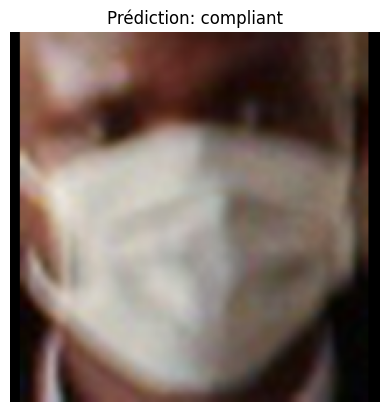

In [28]:
# Function to randomly select an image from the test directory
def get_random_image_from_test_dir(test_dir):
    # Collect all image paths from subdirectories
    image_paths = []
    for root, _, files in os.walk(test_dir):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):  # Supported image formats
                image_paths.append(os.path.join(root, file))
    # Randomly select one image
    return random.choice(image_paths)

# Define the function for prediction
def predict_image(image_path, model, augment, classes):
    transform = get_transforms(augment=augment)
    # Load the image
    image = Image.open(image_path).convert('RGB')
    
    # Apply the transformations
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Pass the image through the model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
    
    # Get the predicted class
    predicted_class = classes[predicted.item()]
    return predicted_class, image

# Load the saved model weights
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)

# Path to the image to be tested
# image_path = "../SF-MASK-dataset-padded/test/non-compliant/FMD_maksssksksss38.png"

# Path to the test directory
test_dir = "../SF-MASK-dataset-padded/test"

# Randomly select an image from the test set
image_path = get_random_image_from_test_dir(test_dir)

# Classes du dataset
classes = train_dataset.classes

# Predict the class of the image
predicted_class, image = predict_image(image_path, model, True, classes)
print(f"La prédiction pour l'image est : {predicted_class}")

# Display the image with its prediction
plt.imshow(image)
plt.title(f"Prédiction: {predicted_class}")
plt.axis("off")
plt.show()




### **1. Méthodes pour la recherche d'hyperparamètres**
- **Grid Search** :
  Explore toutes les combinaisons possibles d'un ensemble prédéfini d'hyperparamètres. Exhaustive mais coûteuse en temps.
- **Random Search** :
  Choisit des combinaisons aléatoires d'hyperparamètres dans un espace défini. Plus rapide que Grid Search.
- **Bayesian Optimization** :
  Utilise des techniques probabilistes pour choisir les hyperparamètres à tester, en optimisant les performances en moins d'essais.
- **Bibliothèques spécialisées** :
  Utiliser des outils comme **Optuna**, **Ray Tune**, ou **Scikit-Optimize** pour une recherche d'hyperparamètres avancée.


#### Exemple de recherche d'hyperparamètres avec Grid Search
Voici un exemple en Python utilisant un simple grid search pour optimiser le taux d'apprentissage (lr) et la taille des batchs (batch_size) :

In [ ]:
from itertools import product

# Définir les hyperparamètres à tester
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]
epochs = 30
patience = 5

# Création des combinaisons d'hyperparamètres
param_grid = list(product(learning_rates, batch_sizes))

# Stocker les performances pour chaque configuration
results = []

for lr, batch_size in param_grid:
    print(f"\nTesting with lr={lr}, batch_size={batch_size}")
    
    train_dataset, train_subset, val_subset , test_subset, train_loader, val_loader, test_loader = get_dataloaders(
    train_dir=output_dir_train, 
    test_dir=output_dir_test, 
    augment=True,
    batch_size=batch_size
    )
    
    # # Mise à jour du DataLoader pour correspondre à la taille des batchs
    # train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialiser le modèle
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, len(train_dataset.classes))
    model = model.to(device)
    
    # Définir la fonction de coût et l'optimiseur
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Entraîner le modèle
    # Get current date and time
    training_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    training_time_name = training_time.replace(" ", "_").replace(":", "-")

    training_time_name = f"lr_{lr}_bs_{batch_size}"
    training_metrics, model_save_path, total_time = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs, training_time_name)
    
    # Évaluer le modèle
    val_accuracy = training_metrics[-1]["val_accuracy"]
    results.append({"model_save_path": model_save_path, "training_time" : training_time ,"lr": lr, "batch_size": batch_size, "val_accuracy": val_accuracy, "training_time": total_time})

# Afficher les meilleurs hyperparamètres
best_config = max(results, key=lambda x: x["val_accuracy"])
print(f"\nBest configuration: lr={best_config['lr']}, batch_size={best_config['batch_size']} with val_accuracy={best_config['val_accuracy']:.2f}%")



Testing with lr=0.01, batch_size=16


c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


size of train_loader : 186, size of val_loader : 47
Training MobileNetV2 for 30 epochs...
Epoch 1/30, Train Loss: 0.7138, Train Accuracy: 67.73%, Val Loss: 0.5786, Val Accuracy: 71.87%, Time: 43.03s
Epoch 2/30, Train Loss: 0.6013, Train Accuracy: 72.11%, Val Loss: 0.5238, Val Accuracy: 78.33%, Time: 40.78s
Epoch 3/30, Train Loss: 0.5716, Train Accuracy: 72.58%, Val Loss: 0.8018, Val Accuracy: 62.58%, Time: 41.36s
Epoch 4/30, Train Loss: 0.4814, Train Accuracy: 79.21%, Val Loss: 0.4548, Val Accuracy: 80.62%, Time: 42.06s
Epoch 5/30, Train Loss: 0.6110, Train Accuracy: 70.83%, Val Loss: 0.5376, Val Accuracy: 72.27%, Time: 41.48s
Epoch 6/30, Train Loss: 0.5270, Train Accuracy: 75.84%, Val Loss: 0.6341, Val Accuracy: 70.52%, Time: 41.36s
Epoch 7/30, Train Loss: 0.5051, Train Accuracy: 78.06%, Val Loss: 0.4971, Val Accuracy: 78.20%, Time: 40.95s
Epoch 8/30, Train Loss: 0.4777, Train Accuracy: 79.34%, Val Loss: 0.4710, Val Accuracy: 79.27%, Time: 41.21s
Epoch 9/30, Train Loss: 0.4603, Train 

In [32]:
results

[{'model_save_path': 'training/mobilenetv2_trained_lr_0.01_bs_16.pth',
  'lr': 0.01,
  'batch_size': 16,
  'val_accuracy': 83.44549125168237,
  'training_time': 1047.5330951213837},
 {'model_save_path': 'training/mobilenetv2_trained_lr_0.01_bs_32.pth',
  'lr': 0.01,
  'batch_size': 32,
  'val_accuracy': 70.39030955585464,
  'training_time': 559.7658398151398},
 {'model_save_path': 'training/mobilenetv2_trained_lr_0.01_bs_64.pth',
  'lr': 0.01,
  'batch_size': 64,
  'val_accuracy': 86.54104979811575,
  'training_time': 2232.7926530838013},
 {'model_save_path': 'training/mobilenetv2_trained_lr_0.001_bs_16.pth',
  'lr': 0.001,
  'batch_size': 16,
  'val_accuracy': 90.84791386271871,
  'training_time': 560.5270953178406},
 {'model_save_path': 'training/mobilenetv2_trained_lr_0.001_bs_32.pth',
  'lr': 0.001,
  'batch_size': 32,
  'val_accuracy': 92.0592193808883,
  'training_time': 1176.7641851902008},
 {'model_save_path': 'training/mobilenetv2_trained_lr_0.001_bs_64.pth',
  'lr': 0.001,
  

In [21]:
best_config["model_save_path"]

NameError: name 'best_config' is not defined

In [ ]:
# Load the saved model weights
best_model_save_path = best_config["model_save_path"] # 'training/mobilenetv2_trained_lr_0.0001_bs_16.pth'
model.load_state_dict(torch.load(best_model_save_path, map_location=device))
model = model.to(device)

In [37]:
# Evaluate the model
accuracy = evaluate_model(model, test_loader)

Accuracy: 94.81%


In [40]:
# Extract model architecture as a dictionary
model_layers = {name: str(layer) for name, layer in model.named_modules()}

metrics = {
    "model_name": model.__class__.__name__, #"MobileNetV2"
    "time started": '2024-11-30 09:30:05' ,
    "training_time_total": total_time,
    "dataset_info": {
        "original_train_dataset_size": len(train_dataset),
        "proportion_used": DATASET_PROPORTION,
        "train_subset_size": len(train_subset),
        "validation_subset_size": len(val_subset),
        "test_subset_size": len(test_subset),
    },
    "training_parameters": {
        "epochs": epochs,
        "batch_size": best_config["batch_size"],
        "learning_rate": best_config["lr"],  # Ensure learning rate is included
    },
    "model_performance": {
        "test accuracy": accuracy,
        "training_metrics": training_metrics,
    },
    "hardware": {
        "device": str(device),
        "model_architecture": model_layers,
    }
}

metrics_file_name = "training_metrics.json"

save_metrics_to_json(metrics, metrics_file_name)


Metrics saved to training_metrics.json


In [ ]:
# Extract the data for plotting
epochs = [m["epoch"] for m in training_metrics]
train_losses = [m["train_loss"] for m in training_metrics]
val_losses = [m["val_loss"] for m in training_metrics]
train_accuracies = [m["train_accuracy"] for m in training_metrics]
val_accuracies = [m["val_accuracy"] for m in training_metrics]
times = [m["time"] for m in training_metrics]

# Plot Training and Validation Loss
loss_fig = go.Figure()
loss_fig.add_trace(go.Scatter(
    x=epochs,
    y=train_losses,
    mode='lines+markers',
    name='Training Loss'
))
loss_fig.add_trace(go.Scatter(
    x=epochs,
    y=val_losses,
    mode='lines+markers',
    name='Validation Loss'
))
loss_fig.update_layout(title="Loss Across Epochs",
                       xaxis_title="Epoch",
                       yaxis_title="Loss")
# Save the loss figure as an HTML file
loss_fig.write_html("./training/training_metrics_plot/loss_plot.html")
loss_fig.show()

# Plot Training and Validation Accuracy
accuracy_fig = go.Figure()
accuracy_fig.add_trace(go.Scatter(
    x=epochs,
    y=train_accuracies,
    mode='lines+markers',
    name='Training Accuracy'
))
accuracy_fig.add_trace(go.Scatter(
    x=epochs,
    y=val_accuracies,
    mode='lines+markers',
    name='Validation Accuracy'
))
accuracy_fig.update_layout(title="Accuracy Across Epochs",
                           xaxis_title="Epoch",
                           yaxis_title="Accuracy")
# Save the accuracy figure as an HTML file
accuracy_fig.write_html(f"./training/training_metrics_plot/accuracy_plot_{training_time_name}.html")
accuracy_fig.show()

# Plot Training Time per Epoch
time_fig = go.Figure()
time_fig.add_trace(go.Scatter(
    x=epochs,
    y=times,
    name='Training Time'
))
time_fig.update_layout(title="Training Time per Epoch",
                       xaxis_title="Epoch",
                       yaxis_title="Time (seconds)")
# Save the time figure as an HTML file
time_fig.write_html(f"training/training_metrics_plot/time_plot_{training_time_name}.html")
time_fig.show()



Voici un résumé des étapes principales et des points forts de du code :

---

### **Résumé des étapes**

1. **Prétraitement des données :**
   - Normalisation des images avec `ToTensor` et `Normalize` (important pour stabiliser l'entraînement).
   - Découpage en sous-ensembles pour entraîner, valider et tester les données.

2. **Fine-tuning de MobileNetV2 :**
   - Utilisation du modèle pré-entraîné pour le **transfert d’apprentissage**.
   - Adaptation de la dernière couche `classifier[1]` pour s’adapter au nombre de classes du dataset.

3. **Entraînement du modèle :**
   - Implémentation d'une boucle d'entraînement classique avec :
     - Calcul de la perte (CrossEntropyLoss).
     - Optimisation (Adam).
     - Suivi des métriques (précision, perte moyenne par époque).
     - Évaluation périodique sur le jeu de validation.

4. **Évaluation :**
   - Calcul de l’**exactitude (accuracy)** sur le jeu de test pour évaluer les performances finales.

5. **Sauvegarde des résultats :**
   - Exportation du modèle entraîné dans un fichier `.pth`.
   - Création d’un fichier JSON contenant des informations clés :
     - Paramètres d’entraînement (batch size, learning rate, nombre d’époques).
     - Performances sur les données de test.
     - Architecture du modèle (MobileNetV2 détaillé).

---

### **Forces du pipeline**

- **Modularité** : Vos fonctions (`train_model` et `evaluate_model`) sont bien encapsulées, facilitant la réutilisation.
- **Système de journalisation des résultats** :
  - Suivi des métriques à chaque époque.
  - Sauvegarde structurée dans un fichier JSON.
- **Support du fine-tuning** : Utilisation d’un modèle pré-entraîné pour accélérer la convergence sur un petit dataset.
- **Gestion des données** :
  - Division stratifiée pour maximiser la diversité dans les ensembles d’entraînement, validation et test.

---

### **Suggestions d'amélioration :**

1. **Appliquer l'arrêt anticipé (early stopping)** :
   - Arrêter l'entraînement automatiquement si la perte de validation stagne pendant plusieurs époques.

2. **Augmentation des données** :
   - Utiliser des transformations supplémentaires (rotation, recadrage, etc.) pour augmenter artificiellement la taille du dataset d’entraînement.

3. **Validation croisée** :
   - Pour des datasets très limités, envisager une validation croisée pour mieux évaluer les performances.

4. **Ajout de suivi avec TensorBoard ou WandB** :
   - Visualiser les courbes de perte, les précisions, et les autres métriques en temps réel.

5. **Analyse des erreurs** :
   - Identifier les erreurs du modèle sur le jeu de test (e.g., confusion matrix) pour mieux comprendre ses limitations.

---


## KFold Cross Validation

In [148]:
def kfold_cross_validation(model, dataset, criterion, optimizer, epochs, k_folds=5, training_time_name="model"):
    # Création du KFold
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    fold_metrics = []  # Pour stocker les métriques de chaque pli

    # Diviser le dataset en k plis
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"Training for fold {fold+1}/{k_folds}")
        
        # Diviser le dataset en train et validation pour chaque pli
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Créer des DataLoaders pour chaque pli
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        # Appeler la fonction de formation pour chaque pli
        training_metrics, model_save_path, total_time = train_model(
            model=model, 
            train_loader=train_loader, 
            val_loader=val_loader, 
            test_loader=None,  # Il n'est pas utilisé ici
            criterion=criterion, 
            optimizer=optimizer, 
            epochs=epochs, 
            training_time_name=f"{training_time_name}_fold_{fold+1}"
        )

        # Sauvegarder les métriques du pli
        fold_metrics.append({
            "fold": fold + 1,
            "training_metrics": training_metrics,
            "model_save_path": model_save_path
        })

    return fold_metrics




In [149]:
# Get current date and time
training_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
training_time_name = training_time.replace(" ", "_").replace(":", "-")

fold_metrics = kfold_cross_validation(
    model=model,
    dataset=train_subset,
    criterion=criterion,
    optimizer=optimizer,
    epochs=5,  # Par exemple
    k_folds=5,  # Nombre de plis pour la validation croisée
    training_time_name=f"{model.__class__.__name__}_{training_time_name}"
)

Training for fold 1/5
size of train_loader : 75, size of val_loader : 19
Training MobileNetV2 for 5 epochs...
Epoch 1/5, Train Loss: 0.1275, Train Accuracy: 95.12%, Val Loss: 0.1391, Val Accuracy: 95.13%, Time: 31.84s
Epoch 2/5, Train Loss: 0.1319, Train Accuracy: 94.91%, Val Loss: 0.2080, Val Accuracy: 92.10%, Time: 34.32s
Epoch 3/5, Train Loss: 0.1173, Train Accuracy: 95.62%, Val Loss: 0.1893, Val Accuracy: 93.11%, Time: 34.57s
Epoch 4/5, Train Loss: 0.1000, Train Accuracy: 96.55%, Val Loss: 0.1420, Val Accuracy: 96.13%, Time: 36.15s
Epoch 5/5, Train Loss: 0.1017, Train Accuracy: 96.47%, Val Loss: 0.1377, Val Accuracy: 94.29%, Time: 35.56s
Total training time: 207.82s
Model weights saved to training/mobilenetv2_trained_MobileNetV2_2024-11-29_17-02-57_fold_1.pth
Training for fold 2/5
size of train_loader : 75, size of val_loader : 19
Training MobileNetV2 for 5 epochs...
Epoch 1/5, Train Loss: 0.1124, Train Accuracy: 96.30%, Val Loss: 0.0781, Val Accuracy: 96.30%, Time: 35.55s
Epoch 2/

In [150]:
# Evaluate final model on test set
test_accuracy = evaluate_model(model, test_loader)
plot_confusion_matrix(model, test_loader, classes=train_dataset.classes)

Accuracy: 89.27%


TypeError: plot_confusion_matrix() missing 1 required positional argument: 'device'

In [ ]:
# Extract model architecture as a dictionary
model_layers = {name: str(layer) for name, layer in model.named_modules()}

metrics = {
    "model_name": "MobileNetV2",
    "training_time_total": training_time,
    "dataset_info": {
        "original_train_dataset_size": len(train_dataset),
        "train_subset_size": len(train_subset_augmented),
        "validation_subset_size": len(val_subset),
        "test_subset_size": len(test_subset),
    },
    "training_parameters": {
        "epochs": epochs,
        "batch_size": BATCH_SIZE,
        "learning_rate": optimizer.param_groups[0]["lr"],  # Ensure learning rate is included
    },
    "model_performance": {
        "test accuracy": accuracy,
        "training_metrics": training_metrics,
    },
    "hardware": {
        "device": str(device),
        "model_architecture": model_layers,
    }
}

metrics_file_name = "training_metrics.json"

save_metrics_to_json(metrics, metrics_file_name)


### Predict by hand (KFOLD)

In [ ]:
# Load the saved model weights
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)

# Path to the image to be tested
# image_path = "../SF-MASK-dataset-padded/test/non-compliant/FMD_maksssksksss38.png"

# Path to the test directory
test_dir = "../SF-MASK-dataset-padded/test"

# Randomly select an image from the test set
image_path = get_random_image_from_test_dir(test_dir)

# Classes du dataset
classes = train_dataset.classes

# Predict the class of the image
predicted_class, image = predict_image(image_path, model, transform, classes)
print(f"La prédiction pour l'image est : {predicted_class}")

# Display the image with its prediction
plt.imshow(image)
plt.title(f"Prédiction: {predicted_class}")
plt.axis("off")
plt.show()


C:\Users\Sinbad\AppData\Local\Temp\ipykernel_21636\1607306687.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

FileNotFoundError: [Errno 2] No such file or directory: 'training/mobilenetv2_Kfold_trained_2021-10-06_15-45-00.pth'

# Real time prediction

## Step 1 : Load Model

In [30]:

# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier for binary classification (2 classes: mask/no mask)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)

# Load your trained model weights
model_save_path = "training/mobilenetv2_trained_lr_0.0001_bs_16.pth"
model.load_state_dict(torch.load(model_save_path, map_location=device), strict=False)

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)

# Set the model to evaluation mode
model.eval()

print(f"Model loaded and set to evaluation mode on device: {device}")


C:\Users\Sinbad\AppData\Local\Temp\ipykernel_7588\3606803131.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locati

Model loaded and set to evaluation mode on device: cuda


## Step 2: Webcam Real-Time Detection


In [31]:
# Define preprocessing
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Open webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    img = preprocess(frame).unsqueeze(0).to(device)   # Add batch dimension and move GPU or CPU

    # Make predictions
    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)

    # Annotate the frame
    label = "Mask" if predicted.item() == 0 else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
    cv2.putText(frame, label, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Display the frame
    cv2.imshow("Mask Detection", frame)

    # Break on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


# First/OLD training notebook TENSORFLOW

In [25]:
# Charger les images et les étiquettes
imagePaths = list(paths.list_images(train_dir))  # Path to the train directory
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]  # Extract 'compliant' or 'non-compliant'
    image = load_img(imagePath, target_size=(64, 64))  # Redimensionner à 224x224
    image = img_to_array(image)
    image = preprocess_input(image)  # Prétraitement pour MobileNetV2
    
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

# Convertir les labels en format one-hot
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Diviser en train/test
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)


In [21]:
# Charger MobileNetV2
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(64, 64, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)  # Sortie pour 2 classes

model = Model(inputs=baseModel.input, outputs=headModel)

# Gel des couches de MobileNetV2
for layer in baseModel.layers:
    layer.trainable = False

# Compilation du modèle
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


C:\Users\Sinbad\AppData\Local\Temp\ipykernel_19400\3316388236.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(64, 64, 3)))


In [22]:
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=EPOCHS, batch_size=BS)


Epoch 1/20


c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_318']
Received: inputs=Tensor(shape=(None, 64, 64, 3))
  warnings.warn(msg)


ValueError: Exception encountered when calling AveragePooling2D.call().

[1mNegative dimension size caused by subtracting 7 from 2 for '{{node functional_2_1/average_pooling2d_2_1/AvgPool}} = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 7, 7, 1], padding="VALID", strides=[1, 7, 7, 1]](functional_2_1/out_relu_1/Relu6)' with input shapes: [?,2,2,1280].[0m

Arguments received by AveragePooling2D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 1280), dtype=float32)